### Reproducing the results of Wheler and Kiladis 99

In [1]:
import numpy as np
import xarray as xr
from matplotlib import pyplot as plt
from pywk99.spectrum.spectrum import get_cross_spectrum
from pywk99.timeseries import remove_seasonal_cycle
from pywk99.timeseries import remove_linear_trend
from pywk99.waves import plot_dispersion_relations

In [2]:
import pywk99
pywk99.__version__

'0.4.4_dev'

In [3]:
# run data/download.ipynb to download the example data
slp = xr.open_mfdataset("data/slp.19*.nc").slp.compute()
olr = xr.open_dataset("data/olr.2xdaily.1979-2022.nc").sel(time=slice("1979", "1995")).resample({"time": "1D"}).mean().olr.compute()
variables = xr.Dataset({"olr": olr, "slp": slp})
variables = variables.sortby("lat")

In [4]:
variables_normalized = remove_linear_trend(variables)
variables_normalized = remove_seasonal_cycle(variables_normalized)

/home/m/m301047/repos/pywk99_mpimet/pywk99/timeseries/timeseries.py:34: UserWarning: Converting non-nanosecond precision timedelta values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  data_time_span = data_time_span.astype("timedelta64[D]")


In [5]:
window_length = "92D"
overlap_length = "60D"
data_frequency = "1D"
taper_alpha = 0.1
symmetric_spectrum = get_cross_spectrum(variables_normalized, "symmetric",
                                        data_frequency, window_length,
                                        overlap_length, taper_alpha=taper_alpha)
asymmetric_spectrum = get_cross_spectrum(variables_normalized, "asymmetric",
                                         data_frequency, window_length,
                                         overlap_length, taper_alpha=taper_alpha)

In [9]:
symmetric_spectrum

<xarray.Dataset>
Dimensions:     (frequency: 45, wavenumber: 144)
Coordinates:
  * frequency   (frequency) float64 0.01099 0.02198 0.03297 ... 0.4835 0.4945
  * wavenumber  (wavenumber) int64 -71 -70 -69 -68 -67 -66 ... 67 68 69 70 71 72
Data variables:
    spectra1    (frequency, wavenumber) float64 736.5 754.1 ... 704.2 695.1
    spectra2    (frequency, wavenumber) float64 1.325e+03 1.318e+03 ... 171.7
    cross       (frequency, wavenumber) complex128 (-0.8578259401622805-25.07...
    cho2        (frequency, wavenumber) float64 0.000645 0.0005709 ... 1.426e-05
    phase       (frequency, wavenumber) float64 -1.605 -2.628 ... -1.565 -0.5129

In [ ]:
COHERENCE_THRESHOLD = 0.05
coh2 = symmetric_spectrum["coherence_squared"]
coh2 = coh2.where(coh2 > COHERENCE_THRESHOLD, drop=True)
u = xr.apply_ufunc(np.real, symmetric_spectrum.cross) / np.abs(symmetric_spectrum.cross)
v = xr.apply_ufunc(np.imag, symmetric_spectrum.cross) / np.abs(symmetric_spectrum.cross)
u = u.where(coh2 > COHERENCE_THRESHOLD, drop=True)
v = v.where(coh2 > COHERENCE_THRESHOLD, drop=True)

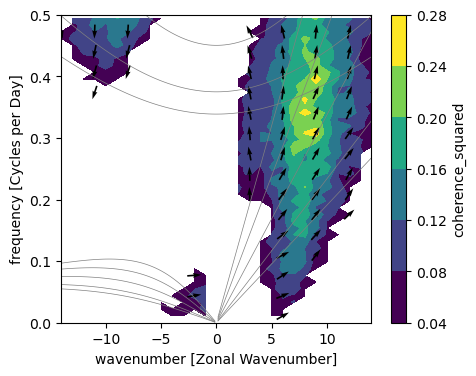

In [ ]:
fig, ax = plt.subplots(1 , 1, figsize=(5, 4))
np.sqrt(coh2).plot.contourf(ax=ax)
stride = 3
ax.quiver(u.wavenumber[::stride],
          u.frequency[::stride],
          u[::stride,::stride],
          v[::stride,::stride],
          angles="uv", pivot='mid', units='x', width=0.15)
plot_dispersion_relations("symmetric", ax, w_max=0.5)